In [0]:
# Подключение к Google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### * Домашнее задание: Многоклассовая классификация

В текущем домашнем задание предлагается построить модель многоклассовой классификации для показателя `RiskVar`. Воспользуемся другими частями датасета freMPL (1 и 2).

In [0]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin

def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/freMPL-R.csv', low_memory=False)

In [0]:
df = df.loc[df.Dataset.isin([1, 2])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [0]:
df.Gender, GenderRef = SeriesFactorizer(df.Gender)
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)
df['SocioCateg'] = df.SocioCateg.str.slice(0,4)
df.VehMaxSpeed, unique = pd.factorize(df.VehMaxSpeed, sort=True)
print({x: i for x, i in enumerate(unique)})
df.VehAge.replace({'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6-7': 6, '8-9': 8, '10+': 10}, inplace=True)
df = pd.get_dummies(df, columns=['VehUsage','SocioCateg', 'VehBody', 'VehPrice', 'VehEngine', 'VehEnergy', 'VehClass', 'Garage'])
df = df.select_dtypes(exclude=['object'])

{0: 'Female', 1: 'Male'}
{0: 'Other', 1: 'Alone'}
{0: '1-130 km/h', 1: '130-140 km/h', 2: '140-150 km/h', 3: '150-160 km/h', 4: '160-170 km/h', 5: '170-180 km/h', 6: '180-190 km/h', 7: '190-200 km/h', 8: '200-220 km/h', 9: '220+ km/h'}


In [0]:
# df.info()

XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде `[0, num_classes]`. Поэтому, вычтем из значений переменной `RiskVar` единицу.

In [0]:
df['RiskVar'] = df.RiskVar - 1

Данная переменная принимает значения от 1 до 20, которые, возможно, упорядочены. Посмотрим, сколько полисов соответствуют каждому из значений `RiskVar`, используя метод `groupby`. Для полученных значений также посчитаем нормированную частоту.

In [0]:
FreqCount = pd.DataFrame(df.groupby('RiskVar').size(), columns=['Count'])
FreqCount['Freq'] = FreqCount.Count / len(df)

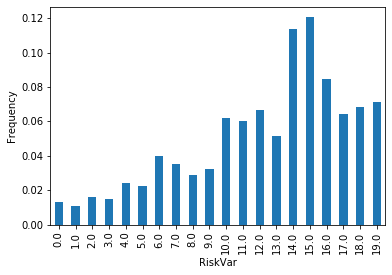

In [0]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

In [0]:
FreqCount

,Count,Freq
RiskVar,,
0.0,531,0.013036
1.0,451,0.011072
2.0,660,0.016203
3.0,603,0.014804
4.0,979,0.024035
5.0,902,0.022145
6.0,1634,0.040116
7.0,1439,0.035328
8.0,1170,0.028724


Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец `weight`. Присвоим ему значения `0.5` для значений `RiskVar` 14 и 15, а для остальных - 1. Можем использовать функцию `np.where` и метод `isin` для `pandas.Series`.

In [0]:
df['weight'] = np.where(df.RiskVar.isin([14,15]), 0.5, 1)

Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [0]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['RiskVar'], axis=1), df.RiskVar, test_size=0.3, random_state=10)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)

Далее, создадим объекты `DMatrix` для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр `weight` равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр `data`.

In [0]:
xgb_train = xgb.DMatrix(x_train.drop('weight', axis=1), y_train, weight=x_train.weight)
xgb_valid = xgb.DMatrix(x_valid.drop('weight', axis=1), y_valid)
xgb_test = xgb.DMatrix(x_test.drop('weight', axis=1), y_test)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Для оптимизации гиперпараметров можно воспользоваться различными методами. Однако, в случае Hyperopt, на процесс подбора гиперпараметров может уйти немалое количество часов.

In [0]:
def objective(params):
    parameters = {
        'objective': 'multi:softmax',
        'max_depth':  int(params['max_depth']),
        'min_child_weight': params['min_child_weight'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'eta': params['eta'],
        'alpha': params['alpha'],
        'lambda': params['lambda'],
        'num_class': len(df.RiskVar.unique())
    }
    
    cv_result = xgb.cv(parameters, xgb_train, num_boost_round=int(params['num_boost_round']), nfold=5, seed=0, maximize=False, early_stopping_rounds=10)
    score = cv_result['test-merror-mean'][-1:].values[0] # multiclass error rate
    return score

In [0]:
space = {'num_boost_round': hp.quniform('num_boost_round', 50, 500, 1),
         'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
         'min_child_weight': hp.uniform('min_child_weight', 0, 50),
         'subsample': hp.uniform('subsample', 0.5, 1),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
         'alpha': hp.uniform('alpha', 0, 1),
         'lambda': hp.uniform('lambda', 0, 1),
         'eta': hp.uniform('eta', 0.01, 1)
        }

In [0]:
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=5)

In [0]:
best_params = space_eval(space, best)
best_params['objective'] = 'multi:softmax'
best_params['num_class'] = len(df.RiskVar.unique())
best_params

{'alpha': 0.7806818259909052,
 'colsample_bytree': 0.7481970629505451,
 'eta': 0.6043342143240166,
 'lambda': 0.30530560829286646,
 'max_depth': 12,
 'min_child_weight': 2.407420043454822,
 'num_boost_round': 152.0,
 'num_class': 20,
 'objective': 'multi:softmax',
 'subsample': 0.9502323599399922}

In [0]:
best_params  = {'alpha': 0.7806818259909052,
                'colsample_bytree': 0.7481970629505451,
                'eta': 0.6043342143240166,
                'lambda': 0.30530560829286646,
                'max_depth': 12,
                'min_child_weight': 2.407420043454822,
                'num_boost_round': 152.0,
                'num_class': 20,
                'objective': 'multi:softmax',
                'subsample': 0.9502323599399922}

In [0]:
xgb_multiclass = xgb.train(num_boost_round=int(best_params.pop('num_boost_round')), params=best_params, dtrain=xgb_train,
                           maximize=False, evals=[(xgb_train, "train"),(xgb_valid, "valid")], early_stopping_rounds=20)

[0]	train-merror:0.759958	valid-merror:0.871031
Multiple eval metrics have been passed: 'valid-merror' will be used for early stopping.

Will train until valid-merror hasn't improved in 20 rounds.
[1]	train-merror:0.657273	valid-merror:0.836498
[2]	train-merror:0.603767	valid-merror:0.820458
[3]	train-merror:0.540616	valid-merror:0.80802
[4]	train-merror:0.491416	valid-merror:0.801964
[5]	train-merror:0.443626	valid-merror:0.789853
[6]	train-merror:0.400679	valid-merror:0.781015
[7]	train-merror:0.36825	valid-merror:0.776923
[8]	train-merror:0.330621	valid-merror:0.770049
[9]	train-merror:0.308075	valid-merror:0.76383
[10]	train-merror:0.280787	valid-merror:0.756137
[11]	train-merror:0.256753	valid-merror:0.752373
[12]	train-merror:0.233374	valid-merror:0.749591
[13]	train-merror:0.214023	valid-merror:0.745499
[14]	train-merror:0.190069	valid-merror:0.741244
[15]	train-merror:0.173061	valid-merror:0.739444
[16]	train-merror:0.155854	valid-merror:0.738789
[17]	train-merror:0.14083	valid

In [0]:
dfsets = [{'set': 'train', 'dmat': xgb_train, 'target': y_train}, {'set': 'valid', 'dmat': xgb_valid, 'target': y_valid}, {'set': 'test', 'dmat': xgb_test, 'target': y_test}]
for dfset in dfsets:
    class_preds = xgb_multiclass.predict(dfset['dmat'])
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset['target'], class_preds, average='micro'))

F1 Score on train: 0.9999649270482603
F1 Score on valid: 0.3454991816693944
F1 Score on test: 0.3432078559738134


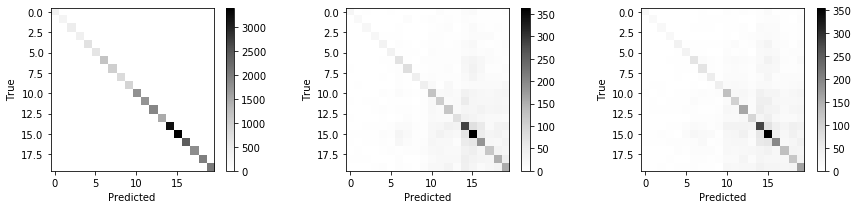

In [0]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], xgb_multiclass.predict(dfsets[i]['dmat']))
    plt.subplot(1,3,i+1); plt.imshow(confmatrix, cmap='Greys'); plt.colorbar(); plt.ylabel('True'); plt.xlabel('Predicted')
plt.show()

Качество, плохое, проблема дисбаланса классов никуда не ушла, а обучающую выборку мы и вовсе запомнили. А на валидации и тесте имеем F-меру 0.34. Явное переобучение. С другой стороны, у нас имеется какой-никакой бейслайн.

In [0]:
df.drop('weight', axis=1, inplace=True)

Создадим укрупненные классы:

In [0]:
df['AggClass'] = np.where(df.RiskVar < 10, 0, np.nan)
df['AggClass'] = np.where(df.RiskVar.isin([10,11,12,13]), 1, df.AggClass)
df['AggClass'] = np.where(df.RiskVar.isin([14,15]), 2, df.AggClass)
df['AggClass'] = np.where(df.RiskVar > 15, 3, df.AggClass)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['RiskVar', 'AggClass'], axis=1), df.AggClass, stratify=df.AggClass, test_size=0.3, random_state=10)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, stratify=y_test, test_size=0.5, random_state=10)

In [0]:
xgb_train = xgb.DMatrix(x_train, y_train)
xgb_valid = xgb.DMatrix(x_valid, y_valid)
xgb_test = xgb.DMatrix(x_test, y_test)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Воспользуемся снова hyperopt.

In [0]:
def objective(params):
    parameters = {
        'objective': 'multi:softmax',
        'max_depth':  int(params['max_depth']),
        'min_child_weight': params['min_child_weight'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'eta': params['eta'],
        'alpha': params['alpha'],
        'lambda': params['lambda'],
        'num_class': len(df.AggClass.unique())
    }
    
    cv_result = xgb.cv(parameters, xgb_train, num_boost_round=250, nfold=3, stratified=True, seed=0, maximize=False, early_stopping_rounds=10)
    score = cv_result['test-merror-mean'][-1:].values[0] # multiclass error rate
    return score

In [0]:
space = {'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
         'min_child_weight': hp.uniform('min_child_weight', 0, 50),
         'subsample': hp.uniform('subsample', 0.5, 1),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
         'alpha': hp.uniform('alpha', 0, 1),
         'lambda': hp.uniform('lambda', 0, 1),
         'eta': hp.uniform('eta', 0.01, 1)
        }

In [0]:
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50)

100%|██████████| 50/50 [1:43:48<00:00, 126.59s/it, best loss: 0.520027]


In [0]:
best_params = space_eval(space, best)
best_params['objective'] = 'multi:softmax'
best_params['num_class'] = len(df.AggClass.unique())
best_params

{'alpha': 0.6655837368198422,
 'colsample_bytree': 0.504833153699499,
 'eta': 0.042528719122902126,
 'lambda': 0.4417650957110083,
 'max_depth': 15,
 'min_child_weight': 0.10297578192998855,
 'num_class': 4,
 'objective': 'multi:softmax',
 'subsample': 0.6317659186200071}

In [0]:
xgb_4classes = xgb.train(num_boost_round=250, params=best_params, dtrain=xgb_train,
                           maximize=False, evals=[(xgb_valid, "valid")], early_stopping_rounds=20)

[0]	valid-merror:0.647463
Will train until valid-merror hasn't improved in 20 rounds.
[1]	valid-merror:0.618822
[2]	valid-merror:0.600164
[3]	valid-merror:0.596563
[4]	valid-merror:0.591817
[5]	valid-merror:0.585106
[6]	valid-merror:0.572177
[7]	valid-merror:0.564321
[8]	valid-merror:0.554664
[9]	valid-merror:0.548609
[10]	valid-merror:0.546972
[11]	valid-merror:0.543863
[12]	valid-merror:0.540753
[13]	valid-merror:0.534697
[14]	valid-merror:0.531588
[15]	valid-merror:0.530933
[16]	valid-merror:0.523895
[17]	valid-merror:0.518985
[18]	valid-merror:0.517676
[19]	valid-merror:0.512439
[20]	valid-merror:0.511784
[21]	valid-merror:0.510966
[22]	valid-merror:0.507201
[23]	valid-merror:0.507038
[24]	valid-merror:0.501964
[25]	valid-merror:0.502782
[26]	valid-merror:0.501146
[27]	valid-merror:0.5
[28]	valid-merror:0.497054
[29]	valid-merror:0.49329
[30]	valid-merror:0.491653
[31]	valid-merror:0.493126
[32]	valid-merror:0.490344
[33]	valid-merror:0.491653
[34]	valid-merror:0.490835
[35]	valid-

In [0]:
dfsets = [{'set': 'train', 'dmat': xgb_train, 'target': y_train}, {'set': 'valid', 'dmat': xgb_valid, 'target': y_valid}, {'set': 'test', 'dmat': xgb_test, 'target': y_test}]
for dfset in dfsets:
    class_preds = xgb_4classes.predict(dfset['dmat'])
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset['target'], class_preds, average='micro'))

F1 Score on train: 0.9952651515151515
F1 Score on valid: 0.5515548281505729
F1 Score on test: 0.5582651391162029


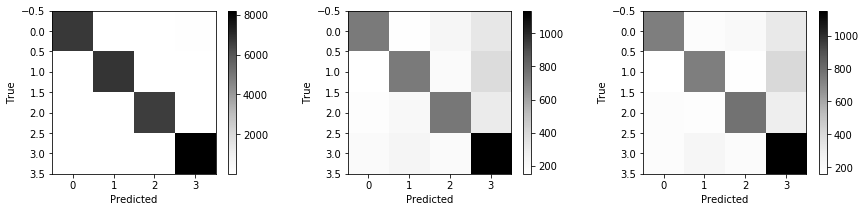

In [0]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], xgb_4classes.predict(dfsets[i]['dmat']))
    plt.subplot(1,3,i+1); plt.imshow(confmatrix, cmap='Greys'); plt.colorbar(); plt.ylabel('True'); plt.xlabel('Predicted')
plt.show()

Заметим, что давже в случае укрупненных классов нам не удалось с высокой точностью классифицировать переменную Riskvar. В задании мы исходили из предположения, что данная переменная может характеризовать степень риска для каждого из представленных полисов. Однако, вероятно, в реальности эта переменная не несет информацию о полисе, из-за чего не удается построить более точный классификатор. Соответственно, при построении моделей необходимо учитывать природу исследуемого показателя или процесса и использовать для этого релевантные данные.